In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
! ls

gaits.csv            log_trajectories.csv walk_analyser.ipynb


In [3]:
df = pd.read_csv('./log_trajectories.csv')
walk_data = df.loc[:, "obs_32":"obs_37"]
walk_data = walk_data.applymap(lambda x: 0 if x < 0 else 1)
walk_data.head(5)

,obs_32,obs_33,obs_34,obs_35,obs_36,obs_37
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

def draw_feet_graph(feet_data, feet_names, feet_colors, delta=0.2, max_length=500, graph_label=None):
    foot_count = len(feet_names)
    yspan = foot_count
    yplaces = [.5 + i for i in range(yspan)]
    ylabels = feet_names

    fig = plt.figure(figsize=(10, 3), dpi=100)
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0, yspan))
    ax.set_xlim((0, max_length))
    if graph_label is not None:
        ax.set_xlabel(graph_label)

    xmin, xmax = ax.get_xlim()
#     ax.hlines(range(1, yspan), xmin, xmax)
    time_step = 0
    vlines = []
    main_foot_curr_contact = False
    main_foot_last_contact = False
    
    for contacts in feet_data:
        if time_step > max_length:
            break
        for i in range(foot_count):
            if contacts[i] < 0.5:
                continue
            start, end = time_step, time_step + 1
            pos = yplaces[i]
            ax.add_patch(patches.Rectangle((start, pos - delta / 2.0), end - start, delta, color=feet_colors[i]))
            
        main_foot_curr_contact = True if contacts[0] > 0.5 else False
        if main_foot_curr_contact is True and main_foot_last_contact is False:
            vlines.append(time_step)
        main_foot_last_contact = main_foot_curr_contact
        time_step += 1
        
    for x in vlines:
        ax.axvline(x,0,1, lw=0.5, color=feet_colors[0])
    fig.canvas.draw()

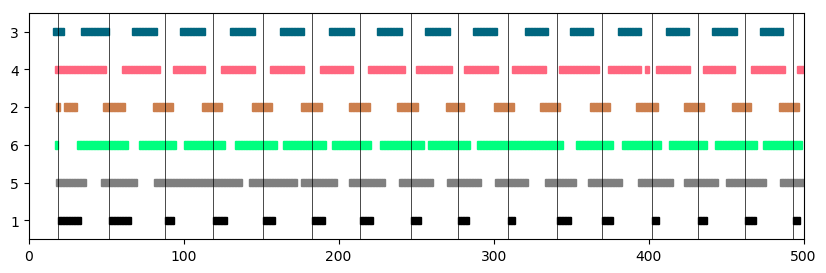

In [11]:
foot_list = ['1', '5', '6', '2', '4', '3']
foot_colors = ['#000000', '#7f7f7f', '#00ff7f', '#cc7f4d', '#ff667f', '#00667f']
draw_feet_graph(walk_data.values, foot_list, foot_colors)

In [51]:
# сделаем нормальный порядок
permutation = [0, 4, 5, 1, 3, 2]
idx = np.argsort(permutation)
trajectory_log = walk_data.values
trajectory_log = trajectory_log[:,idx]

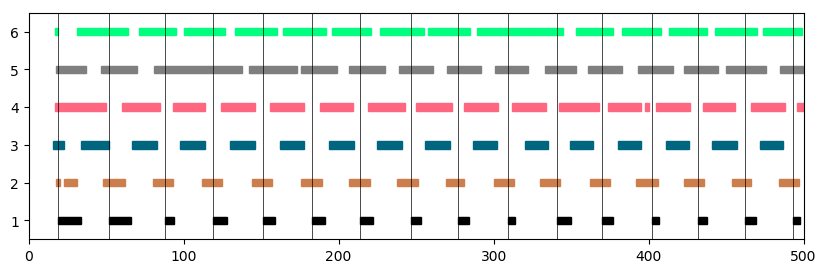

In [52]:
new_foot_colors = ['#000000', '#cc7f4d', '#00667f', '#ff667f', '#7f7f7f', '#00ff7f']
new_foot_list = ['1', '2', '3', '4', '5', '6']
draw_feet_graph(wd,new_foot_list, new_foot_colors)

In [14]:
gdf = pd.read_csv('./gaits.csv')
gdf.head(5)

,gait_name,beta,phi2,phi3,phi4,phi5,phi6
0,galop,0.66,0.00,0.66,0.66,0.33,0.33
1,triple,0.50,0.50,0.50,0.00,0.00,0.50
2,sequence,0.83,0.16,0.33,0.66,0.83,0.50


In [15]:
gaits = gdf.set_index('gait_name').T.to_dict()

In [16]:
def generate_points(d, T):
    feet_data = np.zeros((T,6))
    d["phi1"] = 0
    for i in range(6):
        start_contact = int(T * d["phi"+str(i+1)]) 
        end_contact = int(T * ((d['beta'] + d["phi"+str(i+1)]) % 1))
        if start_contact > end_contact:
#             print("revert")
            for j in range(0, end_contact, 1):
                feet_data[j,i] = 1
            for j in range(end_contact, start_contact, 1):
                feet_data[j,i] = 0
            for j in range(start_contact, T, 1):
                feet_data[j,i] = 1
        else:
            for j in range(start_contact, end_contact, 1):
                feet_data[j,i] = 1
#         print(start_contact, end_contact)
    return feet_data


def draw_gait(d, T=60, cycles=5):
    # сгенерируем точки и отрисуем через draw_feet_graph
    feet_data = generate_points(d, T)
    fd = feet_data
    for i in range(cycles):
        fd = np.concatenate((fd,feet_data))
    draw_feet_graph(fd, new_foot_list, new_foot_colors)

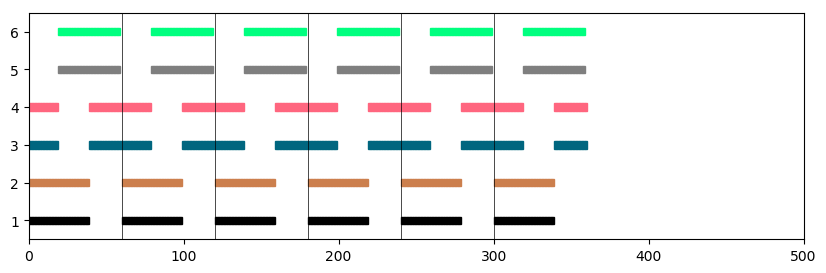

In [17]:
draw_gait(gaits["galop"])

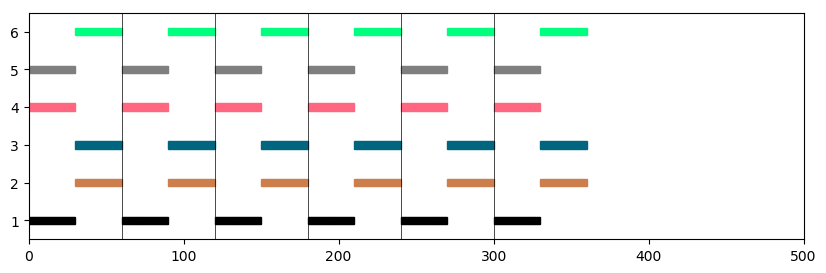

In [208]:
draw_gait(gaits["triple"])

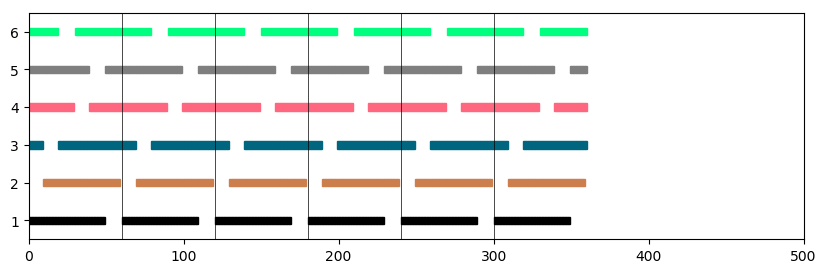

In [209]:
draw_gait(gaits["sequence"])

In [30]:
# генерируем точки для походки в масштабе траектории из лога
def generate_scaled_gait(gait, trajectory_log):
    contact_times = []
    main_foot_curr_contact = False
    main_foot_last_contact = False
    time_step = 0
    
    for contacts in trajectory_log:
        main_foot_curr_contact = True if contacts[0] > 0.5 else False
        if main_foot_curr_contact is True and main_foot_last_contact is False:
            contact_times.append(time_step)
        main_foot_last_contact = main_foot_curr_contact
        time_step += 1
        
    scaled_gait = None
    last_contact_time = 0
    for contact_time in contact_times:
        feet_data = generate_points(gait, contact_time - last_contact_time)
        if scaled_gait is None:
            scaled_gait = feet_data
        else:
            scaled_gait = np.concatenate((scaled_gait,feet_data))
        last_contact_time = contact_time
    # последний цикл походки
    feet_data = generate_points(gait, trajectory_log.shape[0] - last_contact_time)
    scaled_gait = np.concatenate((scaled_gait,feet_data))
    return scaled_gait


def get_feet_error(gait, trajectory_log):
    scaled_gait = generate_scaled_gait(gait, trajectory_log)
    assert(trajectory_log.shape == scaled_gait.shape)
    errors = []
    for i in range(6):
        error = 0
        for j in range(trajectory_log.shape[0]):
            if trajectory_log[j,i] != scaled_gait[j,i]:
                error += 1
        errors.append(error)
    return errors  



In [79]:
def print_error(gait_name):
    feet_errors = get_feet_error(gaits[gait_name], trajectory_log)
    print("contact errors for {} walk\n{}\nsum: {}\naccuracy: {}".format(gait_name, feet_errors, sum(feet_errors),1 - sum(feet_errors)/6000))
    scaled_gait = generate_scaled_gait(gaits[gait_name], trajectory_log)

    draw_feet_graph(scaled_gait,    new_foot_list, new_foot_colors, graph_label="scaled gait",    max_length=150)
    draw_feet_graph(trajectory_log, new_foot_list, new_foot_colors, graph_label="trajectory log", max_length=150)

errors - массив "промахов" в походку для каждой ноги
accuracy - сумма попаданий всех ног к полному числу фреймов, т.е 1 - sum/6000

contact errors for galop walk
[416, 748, 771, 620, 606, 355]
sum: 3516
accuracy: 0.41400000000000003


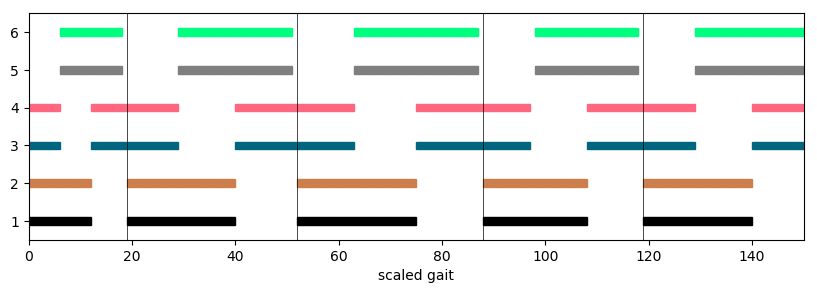

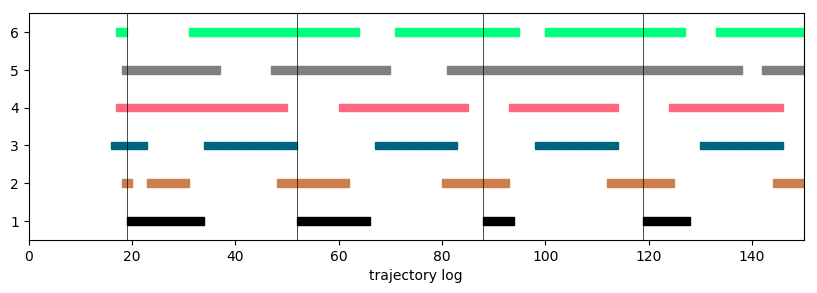

In [76]:
print_error("galop")

contact errors for triple walk
[263, 405, 332, 479, 317, 318]
sum: 2114
accuracy: 0.6476666666666666


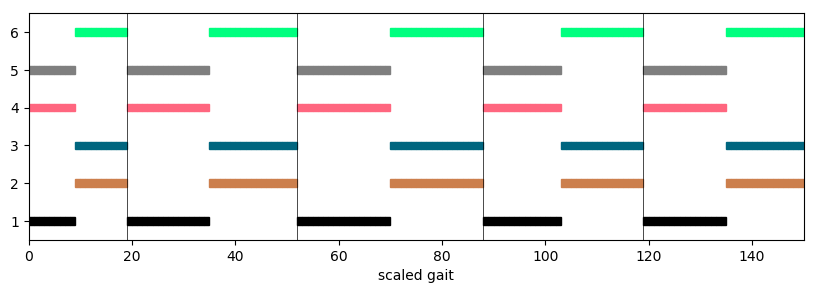

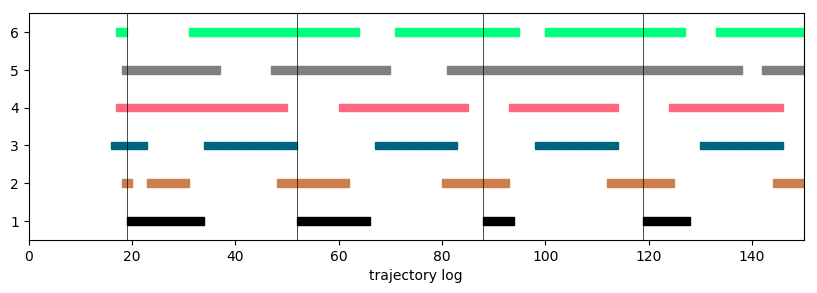

In [77]:
print_error("triple")

contact errors for sequence walk
[581, 735, 332, 455, 238, 190]
sum: 2531
accuracy: 0.5781666666666667


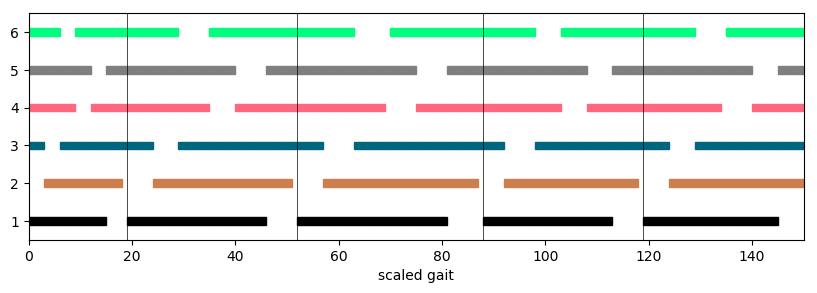

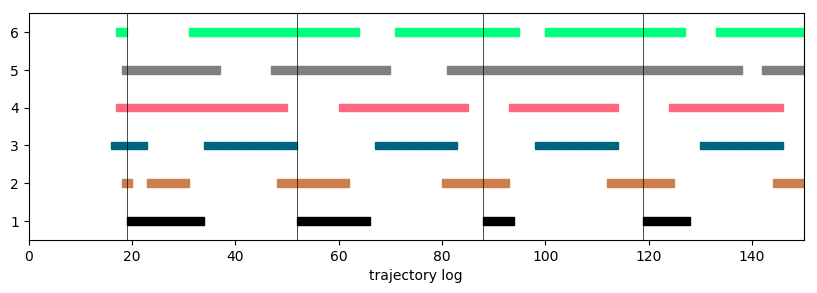

In [78]:
print_error("sequence")